# Capstone Business Problem

## Introduction/Business Problem

I am a huge connoisseur of coffee, and have always harbored a pipe dream of opening a coffee shop focused on simple, but elevated coffee. The suggested prompt for the assignment got me thinking about where could I open a coffee shop in the city of Atlanta, where I live. Atlanta has some decent coffee, especially within the city limits. However, there are some areas which are devoid of good coffee and therefore could be a good location to open a shop.  

For those who have never visited, Atlanta is a vast city with three major counties: Fulton, Cobb, and Dekalb. Because I cannot find any database regarding the actual suburbs of Atlanta, I'm going to focus on the different Zip codes within the city.

Therefore, **my business problem is**: Where is the best place to open a coffee shop in metro Atlanta?

## Atlanta actually provides really nice documentation about all of the 242 official neighborhoods, so I am simply going to use that.

In [80]:
import requests
import pandas as pd
import numpy as np
import geocoder

In [70]:
import math

# Read in CSV
d = pd.read_csv('atl_neighborhoods.csv')[['NAME','SQMILES']]

### Need to add 'GA' for location search
d['NAME'] = d['NAME'] + ', Atlanta, GA'

### Secondly, I want to constrain the Foursquare search to only the neighborhood, so I am computing a customized radius
custom_radius = []
for ii in range(len(d)):
    #print(d.loc[ii,'SQMILES'])
    custom_radius.append(math.sqrt(d.loc[ii,'SQMILES']/3.14)*1609) #conversion from miles to meters
    
d['RADIUS'] = custom_radius
d.head()

,NAME,SQMILES,RADIUS
0,"Atlanta University Center, Atlanta, GA",0.52,654.776210
1,"Hunter Hills, Atlanta, GA",0.50,642.060899
2,"Bankhead, Atlanta, GA",0.65,732.062058
3,"English Avenue, Atlanta, GA",0.81,817.210108
4,"Adair Park, Atlanta, GA",0.45,609.112451


### This function takes a neighborhood and, using geocoder, finds the associated latitutde and longitude of the centroid

In [63]:
def get_lat_long(name):
    
    # Returning search for zipcode
    g = geocoder.arcgis(name)
    
    # Latitude
    lati = g.lat
    
    # Longitude
    longi = g.lng
    
    return(lati,longi)

### Add longitude and latitutde to dataframe

In [72]:
lat_lookup = []
lng_lookup = []

for n in d['NAME']:
    lati,longi = get_lat_long(n)
    
    lat_lookup.append(lati)
    lng_lookup.append(longi)
    
d['LATITUDE'] = lat_lookup
d['LONGITUDE'] = lng_lookup
d.head() 

,NAME,SQMILES,RADIUS,LATITUDE,LONGITUDE
0,"Atlanta University Center, Atlanta, GA",0.52,654.776210,33.75092,-84.41234
1,"Hunter Hills, Atlanta, GA",0.50,642.060899,33.75848,-84.43129
2,"Bankhead, Atlanta, GA",0.65,732.062058,33.76827,-84.42642
3,"English Avenue, Atlanta, GA",0.81,817.210108,33.76821,-84.41051
4,"Adair Park, Atlanta, GA",0.45,609.112451,33.72997,-84.41044


In [239]:
## Looking at where the locations are
import folium

# create map of New York using latitude and longitude values
map_atl = folium.Map(location=[33.7676338, -84.5606894], zoom_start=13)

# add markers to map
for lat, lng, borough in zip(d['LATITUDE'], d['LONGITUDE'], d['NAME']):
    #label = str(borough)
    #label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=borough,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_atl)  
    
map_atl

# Week 1 Part 2: Data Creaiton

In doing some research for how others go about finding the best coffee shop location, I came across [this page](https://squareup.com/us/en/townsquare/how-to-find-a-coffee-shop-location). With regards to the the Foursquare API, this point seems most salient:

**2. Neighboring businesses**
"When you’re determining the best location for a coffee shop, neighboring businesses can also affect your profitability — both negatively and positively.

It might be obvious to research other local coffee shops to find out where they are established, but your competitors aren’t limited to other coffee shops. If your coffee shop targets customers looking for a quick breakfast, you should keep your eye on quick breakfast alternatives including smoothie joints, juice bars, bagel places, and even fast food chains. While these businesses are all in different categories, they could all be competing with the products you serve.

Neighboring businesses can also help your coffee shop by complementing your offerings. If your coffee shop has a large study space, it might be smart to open near other businesses or a university. This provides an ideal area for employees or students to come in and get work done before or after hours. If you’re targeting customers who seek a midday caffeine buzz, you may want to look at shopping centers where customers need a pick-me-up while walking around and shopping."

Therefore, I am going to look at data analysis which focuses on the locations, in a way that is similar to the lab praticals already completed. Therefore, for this project I will utilize data from the **200 most relevant venues within a search distance of 5000m** (we only have zipcodes, which cover a larger area of space. In testing, this seemed to return better results.



## Part 1: Web Scraping

In [177]:
# Using this function from earlier in the course
def getNearbyVenues(names, latitudes, longitudes, radius):

    venues_list=[]
    for name, lat, lng, rad in zip(names, latitudes, longitudes, radius):
        
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            rad, 
            400)
              
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Getting all the top venues from Atlanta

In [160]:
CLIENT_ID = 'XHZAVLMJZPZ1YERWSOQP0RZSG1JTQV24LLJOC3CHJZBFUCWM' # your Foursquare ID
CLIENT_SECRET = 'FKWRVOLJYEBTMABNFPMRYRJ3JOQLKTDE2JPSZKUGJYHQSAMS' # your Foursquare Secret
VERSION = '20180604'

In [137]:
max(d['RADIUS'])

1575.3406071902102

In [178]:
LIMIT = 100
atl_venues2 = getNearbyVenues(names = d['NAME'],
                             latitudes = d['LATITUDE'],
                             longitudes = d['LONGITUDE'],
                             radius = d['RADIUS'])

In [188]:
atl_venues2.shape

(3143, 7)

In [189]:
atl_venues2.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Atlanta University Center, Atlanta, GA",33.75092,-84.41234,Busy Bee Cafe,33.754577,-84.414024,Southern / Soul Food Restaurant
1,"Atlanta University Center, Atlanta, GA",33.75092,-84.41234,Murrell's Cafe,33.754005,-84.409473,Buffet
2,"Atlanta University Center, Atlanta, GA",33.75092,-84.41234,Mr. Everything,33.754739,-84.416131,Sandwich Place
3,"Atlanta University Center, Atlanta, GA",33.75092,-84.41234,Johnny M's Pizza Bistro,33.754599,-84.417157,Pizza Place
4,"Atlanta University Center, Atlanta, GA",33.75092,-84.41234,Spelman College Museum of Fine Art,33.746060,-84.412137,Art Museum


### Next, looking at some exploratry analysis

In [215]:
# getting Counts
counts = atl_venues2.groupby('Neighborhood').count().sort_values('Venue', ascending = False).reset_index()[['Neighborhood','Venue']]
counts.columns = ['Neighborhood','Count']


Neighborhood    object
Count            int64
dtype: object

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002015B5C6D48>]],
      dtype=object)

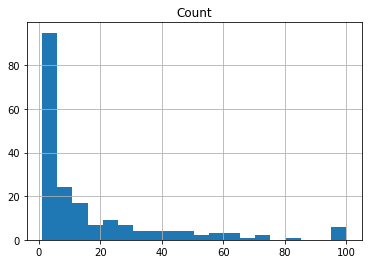

In [209]:
counts.hist(bins=20)

We see a handful of neighborhoods returning less than 10 venues. Those are likely more residential neighborhoods, which are likely not going to be good locations for our coffee shop. Secondly, the *type* of coffee shop is important. My theoreticall coffee shop is not a 'grab-n-go' type place. Therefore, **we will likely require some type of foot traffic** which occurs in areas with more venues. **Therefore, if there are less than 10 locations returned in call, we are not going to include this**.

In [236]:
atl_venues3 = atl_venues2.merge(counts, how = 'left', on = 'Neighborhood')
atl_venues3 = atl_venues3[atl_venues3['Count'] > 10]

#### This at least looks a little better

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002015B89CB48>]],
      dtype=object)

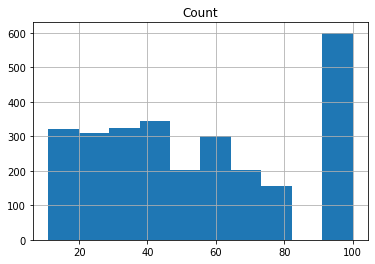

In [237]:
atl_venues3[['Count']].hist()

In [238]:
print('We have reduced our potential neighboorhoods to {} compared to the initial 245'.format(len(atl_venues3['Neighborhood'].unique())))

We have reduced our potential neighboorhoods to 74 compared to the initial 245


In [241]:
atl_venues.columns

Index(['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude',
       'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category'],
      dtype='object')

#### I'm curious as to where these neighborhoods actually are, so plotting the subset.

In [255]:
new_map = atl_venues3[['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude']].groupby('Neighborhood').mean()
new_map = new_map.reset_index()

In [256]:
## Looking at where the locations are

# create map of New York using latitude and longitude values
new_map_atl = folium.Map(location=[33.7868002,-84.3970265], zoom_start=13)

# add markers to map
for lat, lng, borough in zip(new_map['Neighborhood Latitude'], new_map['Neighborhood Longitude'], new_map['Neighborhood']):
    #label = str(borough)
    #label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=borough,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(new_map_atl)  
    
new_map_atl

### For this analysis, I am chosing to do agglmerative clustering

In [257]:
from sklearn.cluster import AgglomerativeClustering 

In [ ]:
#### Doing one hot encoding for the different types of 